In [46]:
import pandas as pd
pd.set_option('display.max_columns', 100)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn')

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve

In [47]:
clientes = pd.read_csv('csv/data_desafio_seguros.csv').drop(columns=['row_id'])

# Renombro las columnas
clientes.rename(columns = {'0':'cuentaCorriente', '1':'meses', '2':'historiaCrediticia', '3':'propositoCredito',
                           '4':'montoCredito', '5':'ahorrosCuenta', '6':'tiempoEmpleoActual', '7':'tasaRentaDisponible',
                           '8':'estatusSexo', '9':'deudoresGarantes', '10':'tiempoResidencia', '11':'posesiones',
                           '12':'edad', '13':'otrosPagos', '14':'vivienda', '15':'numCredito', '16':'tipoTrabajo',
                           '17':'personasResponsable', '18':'telefono', '19':'trabajadorExtranjero', 
                           '20':'tipoCliente'}, inplace=True)

clientes.head()

,cuentaCorriente,meses,historiaCrediticia,propositoCredito,montoCredito,ahorrosCuenta,tiempoEmpleoActual,tasaRentaDisponible,estatusSexo,deudoresGarantes,tiempoResidencia,posesiones,edad,otrosPagos,vivienda,numCredito,tipoTrabajo,personasResponsable,telefono,trabajadorExtranjero,tipoCliente
0,A12,30,A34,A40,4249,A61,A71,4,A94,A101,2,A123,28,A143,A152,2,A174,1,A191,A201,2
1,A14,36,A32,A43,3835,A65,A75,2,A92,A101,4,A121,45,A143,A152,1,A172,1,A192,A201,1
2,A12,12,A34,A41,1804,A62,A72,3,A93,A101,4,A122,44,A143,A152,1,A173,1,A191,A201,1
3,A13,12,A31,A49,609,A61,A72,4,A92,A101,1,A121,26,A143,A152,1,A171,1,A191,A201,2
4,A12,21,A32,A49,2767,A62,A75,4,A91,A101,2,A123,61,A141,A151,2,A172,1,A191,A201,2


In [48]:
clientes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 21 columns):
cuentaCorriente         900 non-null object
meses                   900 non-null int64
historiaCrediticia      900 non-null object
propositoCredito        900 non-null object
montoCredito            900 non-null int64
ahorrosCuenta           900 non-null object
tiempoEmpleoActual      900 non-null object
tasaRentaDisponible     900 non-null int64
estatusSexo             900 non-null object
deudoresGarantes        900 non-null object
tiempoResidencia        900 non-null int64
posesiones              900 non-null object
edad                    900 non-null int64
otrosPagos              900 non-null object
vivienda                900 non-null object
numCredito              900 non-null int64
tipoTrabajo             900 non-null object
personasResponsable     900 non-null int64
telefono                900 non-null object
trabajadorExtranjero    900 non-null object
tipoCliente           

## EDA

In [49]:
clientes['tipoCliente'].value_counts()

1    632
2    268
Name: tipoCliente, dtype: int64

Se observa como está distribuido la cantidad de registros en el dataset donde tenemos claramente mayor cantidad de registros de los casos cuando el cliente es bueno con 632, de lo contrario cuando es malo tenemos 268. Existe un desbalance en las clases.

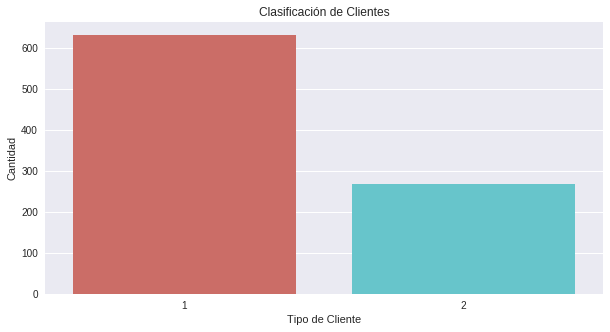

In [50]:
plt.figure(figsize=(10, 5))
sns.countplot(x='tipoCliente', data=clientes, palette='hls')
plt.xlabel("Tipo de Cliente")
plt.ylabel("Cantidad")
plt.title("Clasificación de Clientes")
plt.savefig("tipoCliente");

In [51]:
clienteBueno = len(clientes[clientes['tipoCliente'] == 1])
clienteMalo = len(clientes[clientes['tipoCliente'] == 2])
cantidad = len(clientes)
porcentaje_CB = (clienteBueno / cantidad) * 100
porcentaje_CM = (clienteMalo / cantidad) * 100

print("Porcentaje de Clientes Buenos:", round(porcentaje_CB, 2))
print("Porcentaje de Clientes Malos:", round(porcentaje_CM, 2))

Porcentaje de Clientes Buenos: 70.22
Porcentaje de Clientes Malos: 29.78


Nuestras clases están claramente desbalanceadas, el número de clientes buenos vs malos es de 70:30, antes de continuar haremos una exploración más profunda de datos.

In [52]:
clientes.groupby('tipoCliente').mean()

,meses,montoCredito,tasaRentaDisponible,tiempoResidencia,edad,numCredito,personasResponsable
tipoCliente,,,,,,,
1,19.471519,3015.003165,2.920886,2.857595,36.259494,1.414557,1.153481
2,24.917910,3892.014925,3.104478,2.832090,33.936567,1.358209,1.134328


#### Observaciones:
* La edad del cliente bueno es mayor a la del malo.
* Los meses para pagar el crédito de los clientes buenos es menor (hasta 5 meses menos)  con respecto a los malos.
* El monto del crédito que solicita un cliente bueno es un poco menor al del cliente malo.
* El número de crédito y las personas responsables a cargo no varían tanto, son muy parecidos.

#### Podemos obtener algunos datos relevantes en promedio de las variables categoricas, para así determinar con más sentido la data recopilada.

In [53]:
clientes.groupby('cuentaCorriente').mean()

,meses,montoCredito,tasaRentaDisponible,tiempoResidencia,edad,numCredito,personasResponsable,tipoCliente
cuentaCorriente,,,,,,,,
A11,21.395062,3219.798354,3.053498,2.971193,35.444444,1.358025,1.168724,1.489712
A12,22.644628,3724.223140,2.900826,2.764463,33.880165,1.355372,1.107438,1.384298
A13,17.622951,2181.704918,2.819672,2.573770,37.360656,1.327869,1.147541,1.229508
A14,20.423729,3197.132768,3.000000,2.872881,36.497175,1.466102,1.161017,1.118644


In [54]:
clientes.groupby('ahorrosCuenta').mean()

,meses,montoCredito,tasaRentaDisponible,tiempoResidencia,edad,numCredito,personasResponsable,tipoCliente
ahorrosCuenta,,,,,,,,
A61,20.427509,3171.531599,2.957249,2.765799,35.144981,1.418216,1.139405,1.356877
A62,23.478723,3428.021277,2.968085,2.936170,32.680851,1.382979,1.138298,1.319149
A63,18.816667,2540.600000,2.866667,2.983333,36.783333,1.250000,1.133333,1.183333
A64,19.000000,2624.813953,3.186047,2.767442,37.232558,1.441860,1.162791,1.116279
A65,23.278788,3968.006061,3.024242,3.048485,37.715152,1.381818,1.181818,1.181818


In [55]:
clientes.groupby('tiempoEmpleoActual').mean()

,meses,montoCredito,tasaRentaDisponible,tiempoResidencia,edad,numCredito,personasResponsable,tipoCliente
tiempoEmpleoActual,,,,,,,,
A71,20.842105,4242.824561,2.754386,2.947368,40.280702,1.421053,1.070175,1.350877
A72,18.821192,2875.026490,2.874172,2.490066,30.311258,1.291391,1.112583,1.403974
A73,20.624595,3084.948220,2.893204,2.624595,32.941748,1.343042,1.135922,1.307443
A74,23.587097,3671.722581,2.967742,2.787097,33.522581,1.432258,1.167742,1.219355
A75,21.600877,3290.377193,3.214912,3.412281,42.820175,1.513158,1.192982,1.254386


In [56]:
clientes.groupby('estatusSexo').mean()

,meses,montoCredito,tasaRentaDisponible,tiempoResidencia,edad,numCredito,personasResponsable,tipoCliente
estatusSexo,,,,,,,,
A91,21.893617,3800.297872,2.553191,2.595745,38.595745,1.340426,1.063830,1.404255
A92,19.681319,2881.791209,2.853480,2.904762,32.959707,1.326007,1.043956,1.358974
A93,22.305668,3646.117409,3.082996,2.908907,37.637652,1.453441,1.234818,1.257085
A94,18.174419,2116.476744,2.976744,2.476744,30.302326,1.337209,1.023256,1.279070


### Visualizaciones

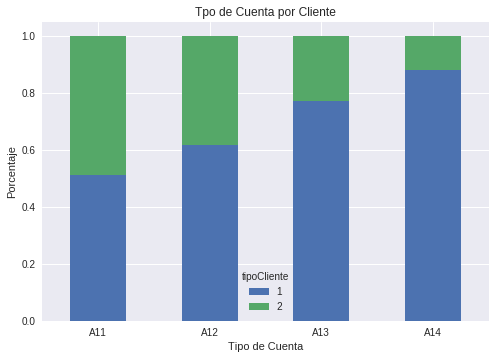

In [57]:
table = pd.crosstab(clientes['cuentaCorriente'], clientes['tipoCliente'])
table.div(table.sum(1), axis=0).plot(kind='bar', stacked=True)
plt.xlabel("Tipo de Cuenta")
plt.xticks(rotation=0)
plt.ylabel("Porcentaje")
plt.title("Tpo de Cuenta por Cliente")
plt.savefig("cuentaCliente");

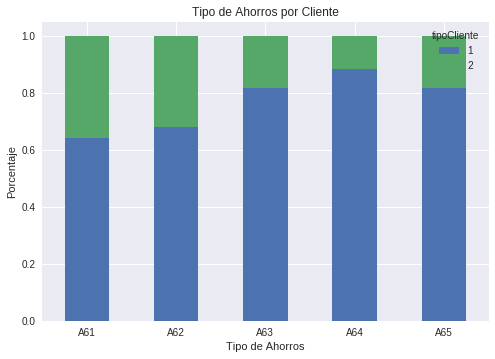

In [58]:
table = pd.crosstab(clientes['ahorrosCuenta'], clientes['tipoCliente'])
table.div(table.sum(1), axis=0).plot(kind='bar', stacked=True)
plt.xlabel("Tipo de Ahorros")
plt.xticks(rotation=0)
plt.ylabel("Porcentaje")
plt.title("Tipo de Ahorros por Cliente")
plt.savefig("ahorrosCliente");

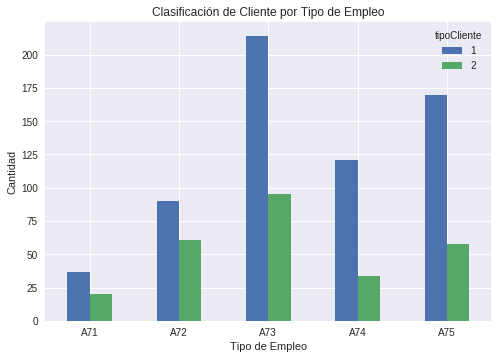

In [59]:
pd.crosstab(clientes.tiempoEmpleoActual, clientes.tipoCliente).plot(kind='bar')
plt.xlabel("Tipo de Empleo")
plt.xticks(rotation=0)
plt.ylabel("Cantidad")
plt.title("Clasificación de Cliente por Tipo de Empleo")
plt.savefig("clasificacionCliente_TipoEmpleo");

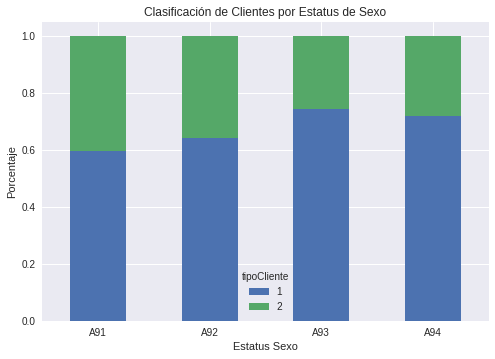

In [60]:
table = pd.crosstab(clientes['estatusSexo'], clientes['tipoCliente'])
table.div(table.sum(1), axis=0).plot(kind='bar', stacked=True)
plt.xlabel("Estatus Sexo")
plt.xticks(rotation=0)
plt.ylabel("Porcentaje")
plt.title("Clasificación de Clientes por Estatus de Sexo")
plt.savefig("clientesporSexo");

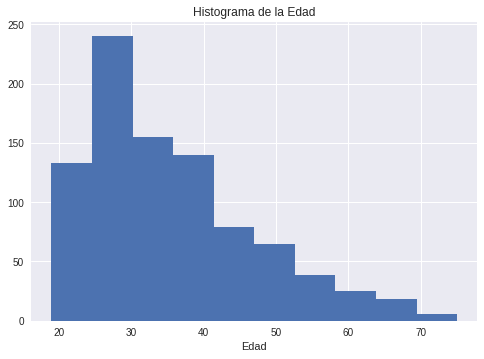

In [61]:
plt.hist(clientes['edad'])
plt.xlabel("Edad")
plt.title("Histograma de la Edad");

La mayoría de los clientes están comprendidos entre el rando de 25 a 35 años.

### Creamos variables dummies al dataset

In [62]:
clientes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 900 entries, 0 to 899
Data columns (total 21 columns):
cuentaCorriente         900 non-null object
meses                   900 non-null int64
historiaCrediticia      900 non-null object
propositoCredito        900 non-null object
montoCredito            900 non-null int64
ahorrosCuenta           900 non-null object
tiempoEmpleoActual      900 non-null object
tasaRentaDisponible     900 non-null int64
estatusSexo             900 non-null object
deudoresGarantes        900 non-null object
tiempoResidencia        900 non-null int64
posesiones              900 non-null object
edad                    900 non-null int64
otrosPagos              900 non-null object
vivienda                900 non-null object
numCredito              900 non-null int64
tipoTrabajo             900 non-null object
personasResponsable     900 non-null int64
telefono                900 non-null object
trabajadorExtranjero    900 non-null object
tipoCliente           

In [63]:
# Recodificación de atributos con 2 categorías
clientes['telefono'] = np.where(clientes['telefono'] == 'A191', 0, 1)
clientes['trabajadorExtranjero'] = np.where(clientes['trabajadorExtranjero'] == 'A202', 0, 1)
clientes['tipoCliente'] = np.where(clientes['tipoCliente'] == 2, 0, 1)

In [64]:
clientes = pd.get_dummies(clientes, columns=['cuentaCorriente', 'historiaCrediticia', 'propositoCredito', 'ahorrosCuenta', 
                                             'tiempoEmpleoActual', 'estatusSexo', 'deudoresGarantes', 'posesiones', 
                                             'otrosPagos', 'vivienda', 'tipoTrabajo'], prefix_sep='_', drop_first=True)

In [65]:
clientes.head()

,meses,montoCredito,tasaRentaDisponible,tiempoResidencia,edad,numCredito,personasResponsable,telefono,trabajadorExtranjero,tipoCliente,cuentaCorriente_A12,cuentaCorriente_A13,cuentaCorriente_A14,historiaCrediticia_A31,historiaCrediticia_A32,historiaCrediticia_A33,historiaCrediticia_A34,propositoCredito_A41,propositoCredito_A410,propositoCredito_A42,propositoCredito_A43,propositoCredito_A44,propositoCredito_A45,propositoCredito_A46,propositoCredito_A48,propositoCredito_A49,ahorrosCuenta_A62,ahorrosCuenta_A63,ahorrosCuenta_A64,ahorrosCuenta_A65,tiempoEmpleoActual_A72,tiempoEmpleoActual_A73,tiempoEmpleoActual_A74,tiempoEmpleoActual_A75,estatusSexo_A92,estatusSexo_A93,estatusSexo_A94,deudoresGarantes_A102,deudoresGarantes_A103,posesiones_A122,posesiones_A123,posesiones_A124,otrosPagos_A142,otrosPagos_A143,vivienda_A152,vivienda_A153,tipoTrabajo_A172,tipoTrabajo_A173,tipoTrabajo_A174
0,30,4249,4,2,28,2,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0,1
1,36,3835,2,4,45,1,1,1,1,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0
2,12,1804,3,4,44,1,1,0,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,1,0
3,12,609,4,1,26,1,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0
4,21,2767,4,2,61,2,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0


### Oversampling

Se aplicará la técnica de Oversampling para aumentar las observaciones de la clase menor (en este caso los clientes malos), implementaremos el método __SMOTE__, consiste en crear observaciones similares de los registros de la clase de clientes malo pero de manera aleatoria.

In [66]:
clientes.shape

(900, 49)

In [67]:
# Se divide la data atributos y target
X = clientes.drop(columns=['tipoCliente'])
Y = clientes.pop('tipoCliente')

In [68]:
# Técnica Hold Out para evaluar posteriormente los datos que no ha visto mi modelo
X_hold_out, X_test_hold_out, y_train_hold_out, y_test_hold_out = train_test_split(X, Y, test_size=0.20, random_state=123)

In [69]:
print(X_hold_out.shape[0])
print(y_train_hold_out.shape[0])

720
720


Podemos apreciar que la cantidad es la misma.

In [70]:
# Divido la data para crear posteriormente un df con clases balanceadas
X_train, X_test, y_train, y_test = train_test_split(X_hold_out, y_train_hold_out,
                                                    test_size=0.30,
                                                    random_state=123)

In [71]:
# Implentación de Oversampling SMOTE
os = SMOTE(random_state=0)
X_train_sampled, y_train_sampled = os.fit_sample(X_train, y_train)
columns = X_train.columns

# Creación de dataframe
os_X = pd.DataFrame(X_train_sampled, columns=columns)
os_Y = pd.DataFrame(y_train_sampled, columns=['y'])

In [72]:
print("Tamaño del Dataset Oversampled: ", len(os_X))
print("Número de Clientes Buenos (Oversampled): ", len(os_Y[os_Y['y'] == 1]))
print("Número de Clientes Malos (Oversampled): ", len(os_Y[os_Y['y'] == 0]))
print("Porcentaje de Clientes Buenos:", round((len(os_Y[os_Y['y'] == 1]) / len(os_X)) * 100))
print("Porcentaje de Clientes Malos:", round((len(os_Y[os_Y['y'] == 1]) / len(os_X)) * 100))

Tamaño del Dataset Oversampled:  722
Número de Clientes Buenos (Oversampled):  361
Número de Clientes Malos (Oversampled):  361
Porcentaje de Clientes Buenos: 50
Porcentaje de Clientes Malos: 50


__Ahora los datos están balanceados perfectamente!!!__

### Implementado Modelo

In [73]:
X = os_X
y = os_Y

#logit_model = sm.Logit(y, X)
#result = logit_model.fit()
#print(result.summary2())

### Modelos:
__1) Logistic Regression__

In [74]:
# Divido la data en training y validation del df con clases balanceadas

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=123)

In [75]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
lr_predict = lr_model.predict(X_test)

In [76]:
print(classification_report(y_test, lr_predict))

              precision    recall  f1-score   support

           0       0.77      0.77      0.77       112
           1       0.75      0.75      0.75       105

    accuracy                           0.76       217
   macro avg       0.76      0.76      0.76       217
weighted avg       0.76      0.76      0.76       217



1.1) Ajuste de Hiperparametros

In [77]:
# GridSearch
penalty = ['l1', 'l2']
C = np.logspace(0, 1, 5)
fit_intercept = ['True', 'False']
param_grid = dict(penalty=penalty, C=C, fit_intercept=fit_intercept)
grid_search = GridSearchCV(LogisticRegression(), param_grid=param_grid, cv=5, n_jobs=-1, verbose=False)
result_lr = grid_search.fit(X_train, y_train)

In [78]:
print("Best Scoring: %f using: %s" %(result_lr.best_score_, result_lr.best_params_))

Best Scoring: 0.760396 using: {'C': 1.0, 'fit_intercept': 'False', 'penalty': 'l1'}


In [80]:
lr_cv = LogisticRegression(C=1, fit_intercept=True, penalty='l1')
lr_cv.fit(X_train, y_train)
lr_predict = lr_cv.predict(X_test)

In [81]:
print(classification_report(y_test, lr_predict))

              precision    recall  f1-score   support

           0       0.76      0.77      0.76       112
           1       0.75      0.74      0.75       105

    accuracy                           0.76       217
   macro avg       0.76      0.76      0.76       217
weighted avg       0.76      0.76      0.76       217



2) Modelo SVC

In [82]:
svc_model = SVC().fit(X_train, y_train)
svc_pred = svc_model.predict(X_test)

In [83]:
print(classification_report(y_test, svc_pred))

              precision    recall  f1-score   support

           0       0.84      0.46      0.60       112
           1       0.61      0.90      0.73       105

    accuracy                           0.68       217
   macro avg       0.73      0.68      0.66       217
weighted avg       0.73      0.68      0.66       217



2.1) Ajustar Hiperparametros

In [84]:
C = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
gamma = [0.0000001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
param_grid = dict(C=C, gamma=gamma)
grid_search = GridSearchCV(SVC(), param_grid=param_grid, cv=5, n_jobs=-1, verbose=False)
result_svc = grid_search.fit(X_train, y_train)

/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [85]:
print("Best Scoring: %f using: %s"%(result_svc.best_score_, result_svc.best_params_))

Best Scoring: 0.693069 using: {'C': 1000, 'gamma': 0.0001}


In [89]:
svc_cv = SVC(C=1000, gamma=0.0001, probability=True)
svc_cv.fit(X_train, y_train)

svc_pred = result_svc.predict(X_test)

In [90]:
print(classification_report(y_test, svc_pred))

              precision    recall  f1-score   support

           0       0.70      0.85      0.77       112
           1       0.79      0.61      0.69       105

    accuracy                           0.73       217
   macro avg       0.74      0.73      0.73       217
weighted avg       0.74      0.73      0.73       217



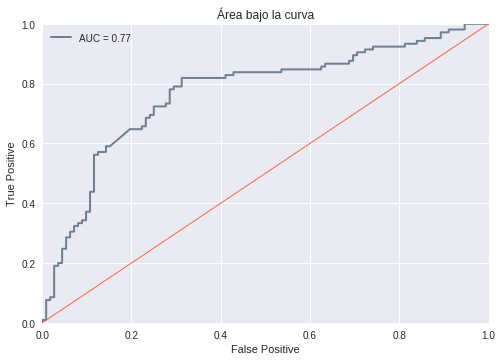

In [91]:
# ROC Curve
svc_proba = svc_cv.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, svc_proba)

fpr, tpr, _ = roc_curve(y_test, svc_proba)

plt.plot(fpr, tpr, label='AUC = {}'.format(round(auc, 3)), color='slategrey', ls='-', lw=2)
plt.xlabel("False Positive")
plt.ylabel("True Positive")
plt.axis([0, 1, 0, 1])

#Clasificador
plt.plot([0, 1], [0, 1], color='tomato', lw=1)
plt.title("Área bajo la curva")
plt.legend();

3) Naive Bayes

In [92]:
nb_model = BernoulliNB().fit(X_train, y_train)
nb_pred = nb_model.predict(X_test)

In [93]:
print(classification_report(y_test, nb_pred))

              precision    recall  f1-score   support

           0       0.78      0.74      0.76       112
           1       0.74      0.78      0.76       105

    accuracy                           0.76       217
   macro avg       0.76      0.76      0.76       217
weighted avg       0.76      0.76      0.76       217



4) Radom Forest

In [94]:
rf_model = RandomForestClassifier().fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

In [95]:
print(classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.81      0.79      0.80       112
           1       0.79      0.80      0.79       105

    accuracy                           0.80       217
   macro avg       0.80      0.80      0.80       217
weighted avg       0.80      0.80      0.80       217



4.1) Ajuste de Hiperparametros

In [96]:
#Listas para guardar los valores temporales
tmp_oob_none, tmp_oob_sqrt, tmp_oob_log2 = [], [], []
n_estimators = range(5, 1000, 20)

In [97]:
#Evaluación de los n_estimators
for i in n_estimators:
    #Implementamos una variante con todos los atributos
    rf_none = RandomForestClassifier(n_estimators=i, max_features=None,
                                     oob_score=True,
                                     random_state=123).fit(X_train, y_train)
    
    #Implementamos una variante donde los atributos se escogen con sqrt
    rf_sqrt = RandomForestClassifier(n_estimators=i, max_features='sqrt',
                                     warm_start=True,
                                     oob_score=True,
                                     random_state=123).fit(X_train, y_train)
    
    #Implementamos una variante donde los atributos se escogen con log2
    rf_log = RandomForestClassifier(n_estimators=i, max_features='log2',
                                    warm_start=True,
                                    oob_score=True,
                                   random_state=123).fit(X_train, y_train)
    
    tmp_oob_none.append(1 - rf_none.oob_score)
    tmp_oob_sqrt.append(1 - rf_sqrt.oob_score)
    tmp_oob_log2.append(1 - rf_log.oob_score)

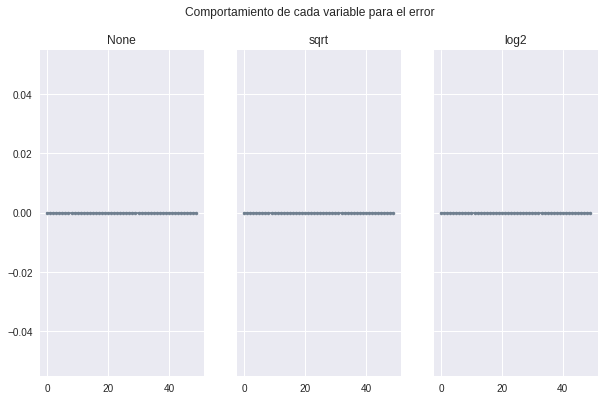

In [98]:
#Graficamos el comportamiento de cada cariable
fig, axs = plt.subplots(1, 3, figsize=(10, 6), sharex=True, sharey=True)

ax1 = axs[0]
ax1.plot(tmp_oob_none, '.-', color='slategrey', label='OOB None')
ax1.set_title("None")

ax2 = axs[1]
ax2.plot(tmp_oob_sqrt, ".-", color='slategrey', label='OOB sqrt')
ax2.set_title("sqrt")

ax3 = axs[2]
ax3.plot(tmp_oob_log2, ".-", color='slategrey', label="OOB log2")
ax3.set_title("log2")

fig.suptitle("Comportamiento de cada variable para el error");

In [99]:
rf_cv = RandomForestClassifier(max_features='log2',n_estimators=5, n_jobs=-1, random_state=5, verbose=False)
rf_cv = rf_cv.fit(X_train, y_train)

rf_cv_pred = rf_cv.predict(X_test)

In [100]:
print(classification_report(y_test, rf_cv_pred))

              precision    recall  f1-score   support

           0       0.88      0.76      0.81       112
           1       0.78      0.89      0.83       105

    accuracy                           0.82       217
   macro avg       0.83      0.82      0.82       217
weighted avg       0.83      0.82      0.82       217



5) XGBoost

In [101]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

xgb_pred = xgb_model.predict(X_test)

In [102]:
print(classification_report(y_test, xgb_pred))

              precision    recall  f1-score   support

           0       0.82      0.79      0.81       112
           1       0.79      0.81      0.80       105

    accuracy                           0.80       217
   macro avg       0.80      0.80      0.80       217
weighted avg       0.80      0.80      0.80       217



5.1) Ajustes de Hiperparametros

In [104]:
# Grid Search
n_estimators = [50, 100, 150, 200, 500]
max_depth = [2, 4, 6, 8]
learning_rate = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
subsample = [i/10.0 for i in range(6,11)]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, subsample=subsample)
grid_search = GridSearchCV(XGBClassifier(), param_grid=param_grid, cv=5, n_jobs=-1, verbose=False)
result_xgb = grid_search.fit(X_train, y_train)

/home/krlos/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [107]:
print("Best scoring: %f using:%s" %(result_xgb.best_score_, result_xgb.best_params_))

Best scoring: 0.847525 using:{'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 200, 'subsample': 0.9}


In [108]:
print(classification_report(y_test, result_xgb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.84      0.79      0.81       112
           1       0.79      0.84      0.81       105

    accuracy                           0.81       217
   macro avg       0.81      0.81      0.81       217
weighted avg       0.81      0.81      0.81       217



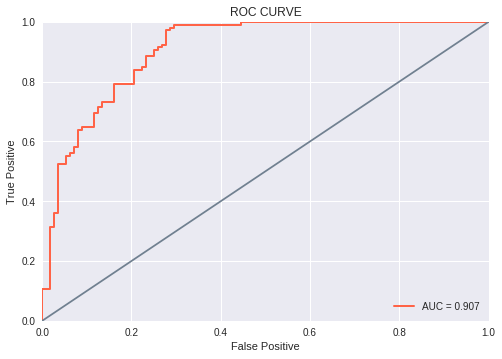

In [110]:
# Roc Curve
xgb_proba = result_xgb.predict_proba(X_test)[:, 1]

auc = roc_auc_score(y_test, xgb_proba)

fpr, tpr, _ = roc_curve(y_test, xgb_proba)

plt.plot(fpr, tpr, label='AUC = {}'.format(round(auc, 3)), color='tomato', ls='-', lw=2)
plt.xlabel("False Positive")
plt.ylabel("True Positive")
plt.title("ROC CURVE")
plt.axis([0, 1, 0, 1])

# Clasificador por chances
plt.plot([0, 1], [0, 1], color='slategrey', ls='-')
plt.legend(loc='lower right');

## Cálculo de la Predicción y la Probabilidad en el dataframe `X_test_hold_out`
El modelo ganador fue el __Random Forest__, implementaré dicho modelo con el set de test que dejé apartado en un inicio con la técnica __Hold Out.__

Por último, haré los cálculos pertinentes para saber el `Precio base del seguro por persona = (3*(1+0.03+p))UF` donde __p=(0.1* score de riesgo)__ , el __score de riesgo__ es igual a la probabilidad de que ese cliente haya sido clasificado como `Bueno o Malo`. 

In [112]:
clientes_test = X_test_hold_out.copy()

In [114]:
clientes_test['prediction'] = rf_cv.predict(X_test_hold_out)
clientes_test['probability'] = rf_cv.predict_proba(X_test_hold_out)[:, 1]

In [118]:
clientes_test.head()

,meses,montoCredito,tasaRentaDisponible,tiempoResidencia,edad,numCredito,personasResponsable,telefono,trabajadorExtranjero,cuentaCorriente_A12,cuentaCorriente_A13,cuentaCorriente_A14,historiaCrediticia_A31,historiaCrediticia_A32,historiaCrediticia_A33,historiaCrediticia_A34,propositoCredito_A41,propositoCredito_A410,propositoCredito_A42,propositoCredito_A43,propositoCredito_A44,propositoCredito_A45,propositoCredito_A46,propositoCredito_A48,propositoCredito_A49,ahorrosCuenta_A62,ahorrosCuenta_A63,ahorrosCuenta_A64,ahorrosCuenta_A65,tiempoEmpleoActual_A72,tiempoEmpleoActual_A73,tiempoEmpleoActual_A74,tiempoEmpleoActual_A75,estatusSexo_A92,estatusSexo_A93,estatusSexo_A94,deudoresGarantes_A102,deudoresGarantes_A103,posesiones_A122,posesiones_A123,posesiones_A124,otrosPagos_A142,otrosPagos_A143,vivienda_A152,vivienda_A153,tipoTrabajo_A172,tipoTrabajo_A173,tipoTrabajo_A174,prediction,probability
613,20,4272,1,4,24,2,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0.2
524,18,1216,4,3,23,1,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0.2
690,24,2896,2,1,29,1,1,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0.4
457,18,1530,3,2,32,2,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0.6
85,15,1403,2,4,28,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0.6


In [122]:
# Cálculo de precio del seguro
UF = 27589.35
p = (0.1 * clientes_test['probability'])

clientes_test['precioSeguro'] = (3 * (1 + 0.03 + p)) * UF
clientes_test['precioSeguro'] = clientes_test['precioSeguro'].apply(lambda x: round(x, 2))

In [123]:
clientes_test.head()

,meses,montoCredito,tasaRentaDisponible,tiempoResidencia,edad,numCredito,personasResponsable,telefono,trabajadorExtranjero,cuentaCorriente_A12,cuentaCorriente_A13,cuentaCorriente_A14,historiaCrediticia_A31,historiaCrediticia_A32,historiaCrediticia_A33,historiaCrediticia_A34,propositoCredito_A41,propositoCredito_A410,propositoCredito_A42,propositoCredito_A43,propositoCredito_A44,propositoCredito_A45,propositoCredito_A46,propositoCredito_A48,propositoCredito_A49,ahorrosCuenta_A62,ahorrosCuenta_A63,ahorrosCuenta_A64,ahorrosCuenta_A65,tiempoEmpleoActual_A72,tiempoEmpleoActual_A73,tiempoEmpleoActual_A74,tiempoEmpleoActual_A75,estatusSexo_A92,estatusSexo_A93,estatusSexo_A94,deudoresGarantes_A102,deudoresGarantes_A103,posesiones_A122,posesiones_A123,posesiones_A124,otrosPagos_A142,otrosPagos_A143,vivienda_A152,vivienda_A153,tipoTrabajo_A172,tipoTrabajo_A173,tipoTrabajo_A174,prediction,probability,precioSeguro
613,20,4272,1,4,24,2,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0.2,86906.45
524,18,1216,4,3,23,1,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0.2,86906.45
690,24,2896,2,1,29,1,1,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0.4,88561.81
457,18,1530,3,2,32,2,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0.6,90217.17
85,15,1403,2,4,28,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0.6,90217.17
